In [1]:
!pip install --upgrade jax jaxlib optax



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


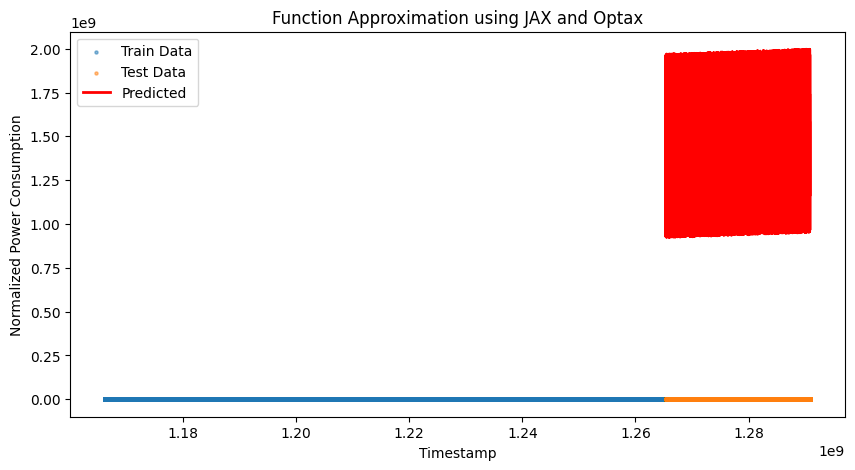

In [2]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax
import optax
from jax import grad, jit, random
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os

# 1️⃣ Download & Extract Dataset if not found
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/household_power_consumption.zip"
zip_path = "household_power_consumption.zip"
txt_path = "household_power_consumption.txt"

if not os.path.exists(txt_path):
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(".")

# 2️⃣ Load & Clean Dataset
df = pd.read_csv(txt_path, sep=';', low_memory=False, na_values='?')

# Convert 'Date' and 'Time' to a single datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Select relevant columns and drop missing values
df = df[['datetime', 'Global_active_power']].dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)

# Normalize data
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df['Global_active_power'] = normalize(df['Global_active_power'])

# 3️⃣ Convert datetime to numerical timestamps
df['timestamp'] = df['datetime'].astype(int) // 10**9  # Convert to Unix timestamps

# Split dataset
train_size = int(0.8 * len(df))
x_train = jnp.array(df['timestamp'][:train_size])
y_train = jnp.array(df['Global_active_power'][:train_size])
x_test = jnp.array(df['timestamp'][train_size:])
y_test = jnp.array(df['Global_active_power'][train_size:])

# 4️⃣ Basis Functions
def polynomial_basis(x, degree=5):
    return jnp.array([x ** i for i in range(degree + 1)]).T.reshape(-1, degree + 1)

# Initialize weights
key = random.PRNGKey(0)
w = random.normal(key, (6,))

# Define loss function
def loss_fn(w, x, y):
    y_pred = jnp.dot(polynomial_basis(x), w)
    return jnp.mean((y - y_pred) ** 2)

# Select optimizer
optim = optax.adam(learning_rate=0.001)
opt_state = optim.init(w)

@jit
def update(w, opt_state, x, y):
    gradients = grad(loss_fn)(w, x, y)
    updates, opt_state = optim.update(gradients, opt_state)
    w = optax.apply_updates(w, updates)
    return w, opt_state

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    w, opt_state = update(w, opt_state, x_train, y_train)

# Predictions
y_pred_train = jnp.dot(polynomial_basis(x_train), w)
y_pred_test = jnp.dot(polynomial_basis(x_test), w)

# 5️⃣ Plot Results
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, label="Train Data", alpha=0.5, s=5)
plt.scatter(x_test, y_test, label="Test Data", alpha=0.5, s=5)
plt.plot(x_test, y_pred_test, label="Predicted", linewidth=2, color='red')
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Normalized Power Consumption")
plt.title("Function Approximation using JAX and Optax")
plt.show()
